# LT026_sample_03

In [62]:
%matplotlib notebook

import pandas as pd
import numpy as np
from shapely import geometry
from shapely.ops import cascaded_union
import matplotlib
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.ndimage import convolve
import math

import os
from pathlib import Path
from datetime import datetime

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Function for creating imaging positions

In [23]:
def get_positions_with_even_number_of_columns(coords, grid_step):
    """
    Process the coordinates of a snake-pattern grid.

    Parameters:
        grid_points (numpy.ndarray): Nx2 array of Euclidean coordinates.
        grid_separation (float): Grid separation step size.

    Returns:
        numpy.ndarray: Modified coordinates with appended transformed positions if needed.
    """
    # Sort coordinates based on x values first (columns), then y values (snake order)
    sorted_coords = coords[coords[:, 0].argsort(kind='mergesort')]
    
    # Extract unique x values (columns) to determine grid size
    unique_x = np.unique(sorted_coords[:, 0])
    num_columns = len(unique_x)

    # Check if the number of columns is odd
    if num_columns % 2 == 0:
        print("Number of columns is even. No modification needed.")
        return coords

    print("Number of columns is odd. Transforming rightmost column...")

    # Identify the rightmost column's x-coordinate
    rightmost_x = unique_x[-1]

    # Extract positions in the rightmost column
    rightmost_column = sorted_coords[sorted_coords[:, 0] == rightmost_x]

    # Invert the order of the rightmost column
    inverted_positions = rightmost_column[::-1]

    # Translate positions to the right by gridStep
    translated_positions = inverted_positions.copy()
    translated_positions[:, 0] += grid_step

    # Append the translated positions to the original coordinates
    expanded_coords = np.vstack((coords, translated_positions))

    return expanded_coords

def find_boundary(coords, grid_step):
    
    # Step 1: Normalize coordinates
    normalized_coords = np.round(coords / grid_step).astype(int)
    min_coords = np.min(normalized_coords, axis=0)
    
    # Step 2: Convert to binary image
    adjusted_coords = normalized_coords - min_coords
    grid_shape = np.max(adjusted_coords, axis=0) + 1
    binary_image = np.zeros(grid_shape, dtype=bool)
    for point in adjusted_coords:
        binary_image[point[0], point[1]] = True
    
    # Step A3: Find boundary pixels (adjacent to background)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbors = convolve(binary_image.astype(int), kernel, mode='constant', cval=0)
    boundary_image = binary_image & (neighbors < 8)
    
    # Step A4: Map boundary pixels back to grid_points indices
    boundary_coords = np.argwhere(boundary_image) + min_coords
    mapping = {tuple(normalized_coords[i]): i for i in range(len(normalized_coords))}
    boundary_indices = [mapping[tuple(coord)] for coord in boundary_coords]
    
    return np.array(boundary_indices)

def reorder_boundary(boundary_indices, coords, start_index):
    # Step B2 & B4: Reorder boundary points starting from `start_index`
    reordered = [start_index]
    remaining = set(boundary_indices) - {start_index}
    current_coord = coords[start_index]
    
    while remaining:
        next_index = min(remaining, key=lambda idx: np.linalg.norm(coords[idx] - current_coord))
        reordered.append(next_index)
        remaining.remove(next_index)
        current_coord = coords[next_index]
    return np.array(reordered)

def get_positions_within_boundary(boundary_path, grid_size, grid_step, direction):

    # Generate grids based on direction
    if direction == 'vertical':
        grid = [
            (x * grid_step, (y if x % 2 == 0 else -y) * grid_step)
            for x in range(-grid_size, grid_size + 1)
            for y in range(-grid_size, grid_size + 1)
        ]
    elif direction == 'horizontal':
        grid = [
            ((x if y % 2 == 0 else -x) * grid_step, y * grid_step)
            for y in range(-grid_size, grid_size + 1)
            for x in range(-grid_size, grid_size + 1)
        ]

    grid = np.array(grid)
    grid_R = grid[::-1]

    # Read input positions
    points = pd.read_csv(boundary_path, header=None, sep=',')
    print(f"{boundary_path} read!")
    print(f"{points.shape[0]} points found.")

    # Define tissue region and center
    tissue = geometry.Polygon(points.values)
    center = np.mean(points.values, axis=0)
    grids = grid + center

    # Filter grids intersecting with tissue
    original = np.array([
        grid_point for grid_point in grids
        if tissue.intersects(
            geometry.Polygon([
                [grid_point[0] - 100, grid_point[1] - 100],
                [grid_point[0] - 100, grid_point[1] + 100],
                [grid_point[0] + 100, grid_point[1] + 100],
                [grid_point[0] + 100, grid_point[1] - 100]
            ])
        )
    ])

    return original


def get_tissue_positions(boundary_path , output_path, grid_size , grid_step , direction='vertical', position_type='simple'):
    
    cache_dir = './cache'
    os.makedirs(cache_dir, exist_ok=True)
    
    # fill the provided boundary with grid positions
    original_positions = get_positions_within_boundary(boundary_path, grid_size, grid_step, direction)
    np.save(f'{cache_dir}/original_positions.npy', original_positions)
    
    if not position_type == 'simple':
    
        # expand positions to have odd number of columns
        expanded_positions = get_positions_with_even_number_of_columns(original_positions, grid_step)
        np.save(f'{cache_dir}/expanded_positions.npy', expanded_positions)

        # get indices of the tissue boundary
        boundary_indices = find_boundary(expanded_positions, grid_step)
        np.save(f'{cache_dir}/boundary_indices.npy', boundary_indices)

        # Reorder boundary starting from the first position
        reordered_boundary_indices = reorder_boundary(boundary_indices, expanded_positions, 0)
        np.save(f'{cache_dir}/reordered_boundary_indices.npy', reordered_boundary_indices)

        # get the boundary index of last point in expanded_positions
        last_point_index = list(reordered_boundary_indices).index(expanded_positions.shape[0]-1)

        # remove the second half of the boundary coordinates from the expanded coordinates
        removed_second_half_of_boundary_positions = np.delete(expanded_positions, reordered_boundary_indices[last_point_index:], axis=0)
        print(removed_second_half_of_boundary_positions.shape[0])

        # get second half of boundary coordinates
        second_half_of_boundary_positions = expanded_positions[reordered_boundary_indices[last_point_index:]]

        # generate final coordinates
        final_positions = np.concatenate([removed_second_half_of_boundary_positions , second_half_of_boundary_positions], axis=0)
        np.save(f'{cache_dir}/final_positions.npy', final_positions)
        np.savetxt(output_path  , final_positions, delimiter=',')
        
    else:
        
        np.save(f'{cache_dir}/expanded_positions.npy'        , original_positions)
        np.save(f'{cache_dir}/boundary_indices.npy'          , original_positions)
        np.save(f'{cache_dir}/reordered_boundary_indices.npy', original_positions)
        np.save(f'{cache_dir}/final_positions.npy'           , original_positions)
        np.savetxt(output_path                               , original_positions, delimiter=',')
        final_positions = original_positions
    
    return final_positions

In [24]:
import os
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union


def load_hole_polygons(hole_dir, pattern="hole*.txt"):
    """
    Read all hole*.txt files in hole_dir and return a list of Shapely Polygons.
    Each file is assumed to be a CSV with lines "X,Y".
    """
    polygons = []
    paths = sorted(glob.glob(os.path.join(hole_dir, pattern)))

    for path in paths:
        coords = []
        with open(path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                x_str, y_str = line.split(",")
                x, y = float(x_str), float(y_str)
                coords.append((x, y))

        # At least 3 points needed for a polygon
        if len(coords) >= 3:
            poly = Polygon(coords)
            if not poly.is_empty and poly.is_valid:
                polygons.append(poly)
        else:
            print(f"Warning: {path} has fewer than 3 points; skipping.")

    return polygons


def remove_points_in_holes(POS, hole_polygons):
    """
    Given:
        POS: numpy array of shape (N, 2) with point coordinates.
        hole_polygons: list of Shapely Polygons.

    Returns:
        filtered_POS: numpy array of shape (M, 2) with points NOT inside any hole.
        mask: boolean array of length N, True where points are kept.
    """
    if len(hole_polygons) == 0:
        # No holes; everything is kept
        mask = np.ones(len(POS), dtype=bool)
        return POS.copy(), mask

    # Combine all hole polygons into a single geometry for faster querying
    holes_union = unary_union(hole_polygons)

    # Build mask: True if point is *not* inside any hole
    mask = []
    for x, y in POS:
        p = Point(x, y)
        # Use contains; you can also consider within or covers depending on your needs
        inside = holes_union.contains(p)
        mask.append(not inside)

    mask = np.array(mask, dtype=bool)
    filtered_POS = POS[mask]
    return filtered_POS, mask


def write_pos_to_hole_format(POS, filename):
    """
    Write POS (N,2) array to a text/CSV file with lines: X,Y
    """
    # Ensure POS is an (N, 2) array
    POS = np.asarray(POS).reshape(-1, 2)

    # Write as CSV with no header, each line "X,Y"
    np.savetxt(
        filename,
        POS,
        delimiter=",",
        fmt="%.6f"  # adjust precision if needed
    )

In [ ]:
exp_name       = 'LT026'
sample_name    = 'sample_03'
sample_id      = f'{exp_name}_{sample_name}' 
local_dir      = f'F:/Data/Leonardo'
exp_dir        = f'{local_dir}/{sample_id}'
settings_dir   = f'{exp_dir}/settings'
notebooks_dir  = f'{exp_dir}/imaging_with_storm_control'
cache_dir      = f'{notebooks_dir}/cache' 
data_dir       = f'{exp_dir}/data'

# create imaging positions

In [25]:
grid_size      = 50
grid_step      = 200
boundary_path  = f'{settings_dir}/boundary_positions.txt'
output_path    = f'{settings_dir}/positions_{sample_id}.txt'
positions      = get_tissue_positions(boundary_path , output_path , grid_size , grid_step, direction='vertical',position_type='closed_loop')

F:/Data/Leonardo/LT026_sample_03/settings/boundary_positions.txt read!
62 points found.
Number of columns is even. No modification needed.
628


In [26]:
# Load hole polygons
hole_polygons = load_hole_polygons(settings_dir)

# Remove POS points that lie inside any hole region
filtered_positions, mask = remove_points_in_holes(positions, hole_polygons)

filtered_positions = filtered_positions[:-2,:]

write_pos_to_hole_format(filtered_positions, f'{settings_dir}/positions_LT026_sample_03_merfish.txt')

<IPython.core.display.Javascript object>


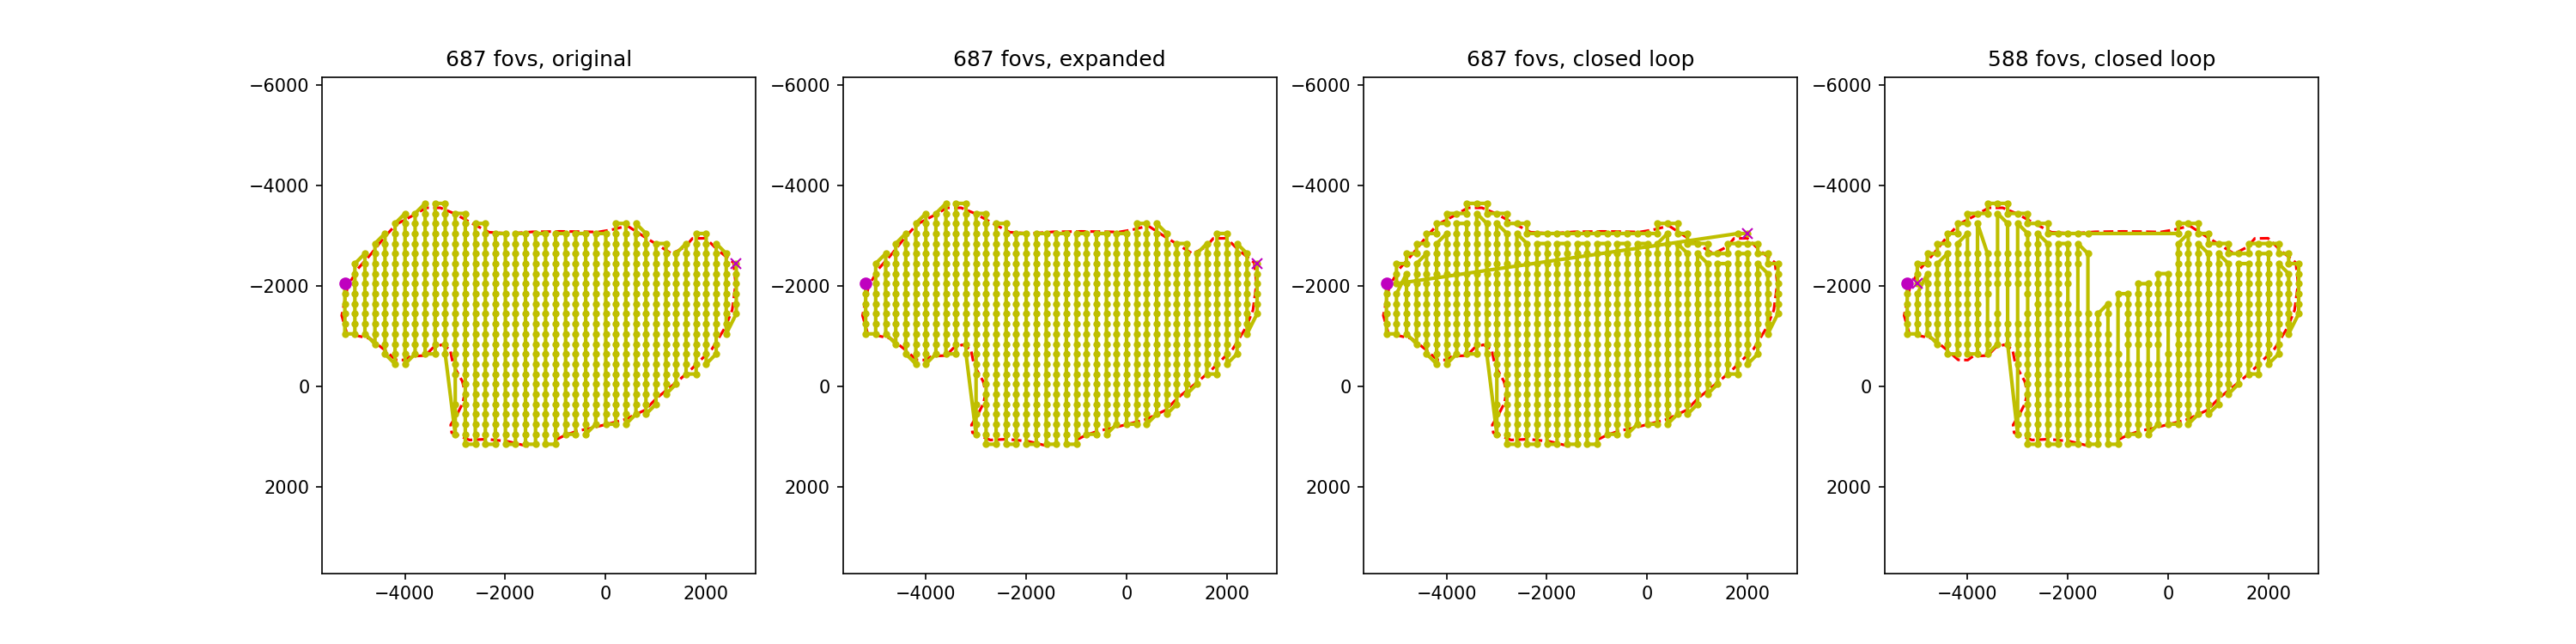

In [28]:
## Display positions
                              
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))    
        
# load original positions file
boundary_positions = pd.read_csv(f'{settings_dir}/boundary_positions.txt', header=None, names=('X','Y'))
original_positions = np.load(f'{cache_dir}/original_positions.npy')

ax[0].plot(boundary_positions.X , boundary_positions.Y , 'r--')
ax[0].plot(original_positions[: ,0] , original_positions[ :,1]  , 'y.-' , lw=2)
ax[0].plot(original_positions[0 ,0] , original_positions[ 0,1]  , 'mo')
ax[0].plot(original_positions[-1,0] , original_positions[-1,1]  , 'mx')
ax[0].axis('equal')
ax[0].set_title(f'{original_positions.shape[0]} fovs, original')
ax[0].invert_yaxis()

expanded_positions = np.load(f'{cache_dir}/expanded_positions.npy')
ax[1].plot(boundary_positions.X , boundary_positions.Y , 'r--')
ax[1].plot(expanded_positions[: ,0] , expanded_positions[ :,1] , 'y.-' , lw=2)
ax[1].plot(expanded_positions[0 ,0] , expanded_positions[ 0,1]  , 'mo')
ax[1].plot(expanded_positions[-1,0] , expanded_positions[-1,1]  , 'mx')
ax[1].axis('equal')
ax[1].set_title(f'{expanded_positions.shape[0]} fovs, expanded')
ax[1].invert_yaxis()

final_positions =  pd.read_csv(f'{output_path}', header=None, names=('X','Y'))
final_positions = final_positions.values
ax[2].plot(boundary_positions.X , boundary_positions.Y , 'r--')
ax[2].plot(final_positions[: ,0] , final_positions[ :,1] , 'y.-' , lw=2)
ax[2].plot(final_positions[0 ,0] , final_positions[ 0,1]  , 'mo')
ax[2].plot(final_positions[-1,0] , final_positions[-1,1]  , 'mx')
ax[2].axis('equal')
ax[2].set_title(f'{final_positions.shape[0]} fovs, closed loop')
ax[2].invert_yaxis()

ax[3].plot(boundary_positions.X , boundary_positions.Y , 'r--')
ax[3].plot(filtered_positions[:,0] , filtered_positions[:,1] ,  'y.-', lw=2)
ax[3].plot(filtered_positions[0 ,0] , filtered_positions[ 0,1]  , 'mo')
ax[3].plot(filtered_positions[-1,0] , filtered_positions[-1,1]  , 'mx')
ax[3].axis('equal')
ax[3].set_title(f'{filtered_positions.shape[0]} fovs, closed loop')
ax[3].invert_yaxis()


In [40]:
# microscope step size

pixel_size_in_microns = 0.109
image_size_in_pixels  = 2048
non_overlap_fraction  = 0.9

step_size = pixel_size_in_microns*image_size_in_pixels*non_overlap_fraction # this will be the step size the stage takes

In [41]:
def read_positions_file(positions_file_path):
    positions_file_dir = os.path.dirname(positions_file_path)
    points = pd.read_csv(positions_file_path, header = None, sep=',').values
    return points

<IPython.core.display.Javascript object>


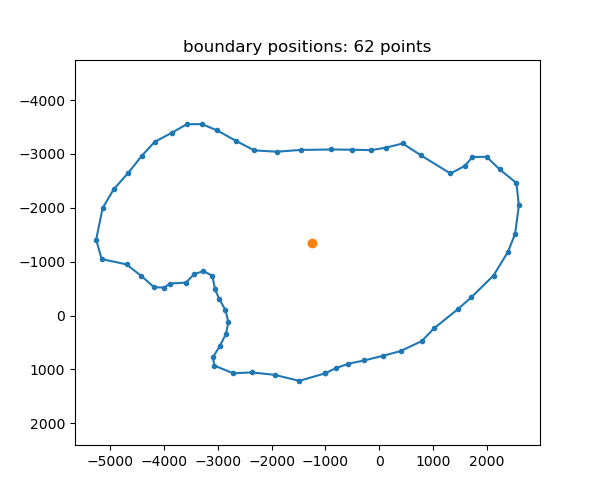

In [42]:
boundary_file_path = '../data/input/boundary_positions.txt'
points = read_positions_file(boundary_file_path)

poly = geometry.Polygon(points)
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(*poly.exterior.xy, '.-')
ax.plot(*poly.centroid.xy,'o')
ax.set_title(f'boundary positions: {len(points)} points')
ax.axis('equal')
ax.invert_yaxis()

In [103]:
def one_dim_coords(center, dmin, dmax, step_size):
    right = np.arange(center + step_size/2, dmax, step_size)
    left  = np.arange(center - step_size/2, dmin, -step_size)[::-1]
    return np.concatenate([left, right])

def one_dim_coords_even(center, dmin, dmax, step_size):
   
    span = dmax - dmin
    n = int(round(span / step_size))   # approximate number of positions

    # ensure even
    if n % 2 == 1:
        n += 1
    if n == 0:
        return np.array([])

    # calculate difference
    d = n*step_size - span
    
    # re-adjust bounds
    dmin = dmin - d/2
    dmax = dmax + d/2
        
    coords =  np.arange(dmin, dmax, step_size)

    return coords

def grid_positions(cx, cy, xmin, ymin, xmax, ymax, step_size):
    xs = one_dim_coords_even(cx, xmin, xmax, step_size)
    ys = one_dim_coords_even(cy, ymin, ymax, step_size)

    # ys increasing: row 0 = bottom, row -1 = top
    Xg, Yg = np.meshgrid(xs, ys)
    grid = np.stack([Xg, Yg], axis=-1)  # shape (H, W, 2)

    return grid, xs, ys

In [104]:
xmin, ymin, xmax, ymax = poly.bounds

# Get scalar centroid coordinates
cx = poly.centroid.x
cy = poly.centroid.y

grid, xs, ys = grid_positions(cx, cy, xmin, ymin, xmax, ymax, step_size)

<IPython.core.display.Javascript object>


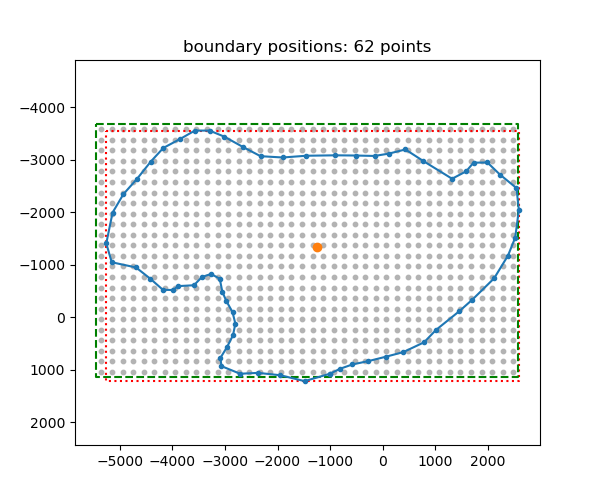

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [105]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

# plot the generated grid
xs = grid[..., 0].ravel()
ys = grid[..., 1].ravel()
ax.scatter(xs, ys, s=10, c=[.7,.7,.7])

# plot the border of the polygon 
(pxmin, pymin, pxmax, pymax) = poly.bounds
poly_x = [pxmin, pxmax, pxmax, pxmin, pxmin]
poly_y = [pymin, pymin, pymax, pymax, pymin]
ax.plot(poly_x, poly_y, 'r:')

# plot the border of the fovs 
fxmin = min(xs) - step_size/2
fxmax = max(xs) + step_size/2
fymin = min(ys) - step_size/2
fymax = max(ys) + step_size/2

fov_x = [fxmin, fxmax, fxmax, fxmin, fxmin]
fov_y = [fymin, fymin, fymax, fymax, fymin]
ax.plot(fov_x, fov_y, 'g--')


# plot boundary and centroid
ax.plot(*poly.exterior.xy, '.-')
ax.plot(*poly.centroid.xy,'o')
ax.set_title(f'boundary positions: {len(points)} points')
ax.axis('equal')
ax.invert_yaxis()



In [106]:
def snake_order(grid, direction="vertical"):
    """
    grid: (H, W, 2) array of positions, as from grid_positions.
    direction: "vertical" or "horizontal".
    Returns: (N, 2) array of positions in snake order.
    """
    H, W, _ = grid.shape
    path = []

    if direction == "vertical":
        # Columns: left -> right
        for j in range(W):
            if j % 2 == 0:
                # even column: top -> bottom (top row is H-1)
                rows = range(H-1, -1, -1)
            else:
                # odd column: bottom -> top
                rows = range(0, H)
            for i in rows:
                path.append(grid[i, j])
    elif direction == "horizontal":
        # Rows: top -> bottom (top row is H-1)
        for i in range(H-1, -1, -1):
            strip = (H-1 - i)  # 0 for top row, 1 for next, etc.
            if strip % 2 == 0:
                # even strip: left -> right
                cols = range(0, W)
            else:
                # odd strip: right -> left
                cols = range(W-1, -1, -1)
            for j in cols:
                path.append(grid[i, j])
    else:
        raise ValueError("direction must be 'vertical' or 'horizontal'")

    return np.array(path)

In [107]:
# Vertical snake
path_vert = snake_order(grid, direction="vertical")

# Horizontal snake
path_horiz = snake_order(grid, direction="horizontal")

<IPython.core.display.Javascript object>


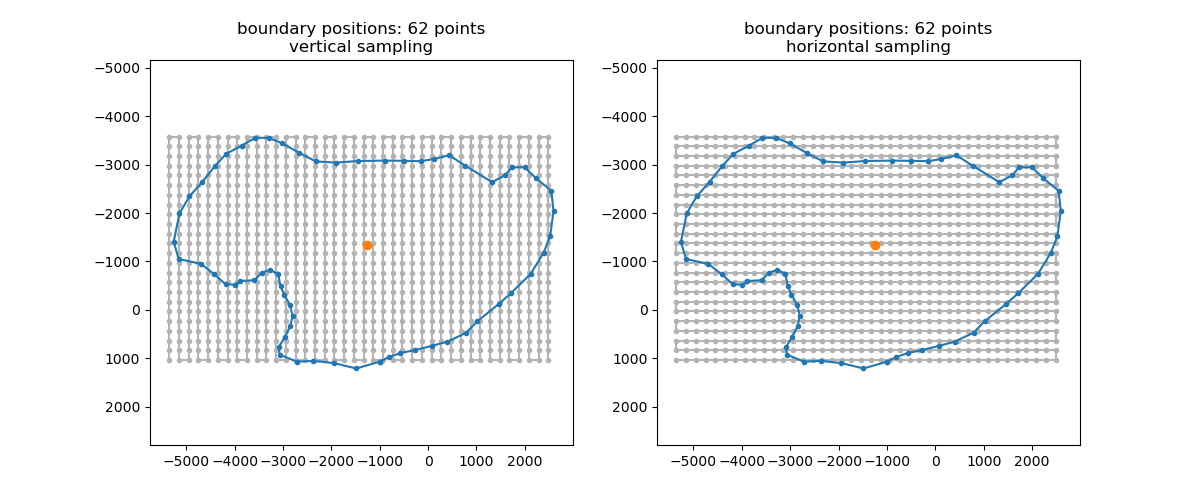

In [109]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))
"""
plot vertical snake
"""
ax[0].plot(path_vert[:,0], path_vert[:,1], '.-', color=[.7,.7,.7])

# plot boundary and centroid
ax[0].plot(*poly.exterior.xy, '.-')
ax[0].plot(*poly.centroid.xy,'o')
ax[0].set_title(f'boundary positions: {len(points)} points\nvertical sampling')
ax[0].axis('equal')
ax[0].invert_yaxis()

"""
plot vertical snake
"""
ax[1].plot(path_horiz[:,0], path_horiz[:,1], '.-', color=[.7,.7,.7])

# plot boundary and centroid
ax[1].plot(*poly.exterior.xy, '.-')
ax[1].plot(*poly.centroid.xy,'o')
ax[1].set_title(f'boundary positions: {len(points)} points\nhorizontal sampling')
ax[1].axis('equal')
ax[1].invert_yaxis()

In [112]:
from pathlib import Path
import csv
from shapely.geometry import Polygon

def load_hole_polygons(hole_dir, pattern="hole*.txt"):
    """
    Read all hole*.txt files in hole_dir and return a list of Shapely Polygons.
    Each file is assumed to be a CSV with lines "X,Y".
    """
    hole_dir = Path(hole_dir)
    polygons = []

    for path in sorted(hole_dir.glob(pattern)):
        with path.open() as f:
            reader = csv.reader(f)
            coords = [(float(x), float(y)) for x, y in reader if x and y]

        if len(coords) < 3:
            print(f"Warning: {path} has fewer than 3 points; skipping.")
            continue

        poly = Polygon(coords)
        if not poly.is_empty and poly.is_valid:
            polygons.append(poly)

    return polygons

In [118]:
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon  # only for typing / clarity

def filter_snake_path(coords, boundary_poly, hole_polygons, dilate=0.0):
    """
    Filter snake_path coordinates so that:
      1) Points lie inside (or on) the boundary polygon (optionally dilated).
      2) Points are NOT inside any of the hole polygons.

    Parameters
    ----------
    spc : array-like of shape (N, 2)
        Snake path coordinates: [[x0, y0], [x1, y1], ...].
    boundary_poly : shapely.geometry.Polygon
        Outer boundary polygon.
    hole_polygons : list of shapely.geometry.Polygon
        List of hole polygons to exclude.
    dilate : float, optional (default=0.0)
        Buffer distance applied to the boundary polygon before checking
        points. Positive dilates (expands), negative erodes (shrinks).

    Returns
    -------
    np.ndarray of shape (M, 2)
        Filtered coordinates in the same order as input.
    """
    coords = np.asarray(coords, dtype=float)

    # Optionally dilate (buffer) the boundary
    boundary = boundary_poly.buffer(dilate) if dilate != 0.0 else boundary_poly

    kept = []
    for x, y in coords:
        p = Point(x, y)

        # 1) Must be inside or on the (possibly dilated) boundary
        if not boundary.covers(p):
            continue

        # 2) Must NOT be inside any hole
        in_hole = any(hole.covers(p) for hole in hole_polygons)
        if in_hole:
            continue

        kept.append((x, y))

    return np.array(kept)

In [126]:
hole_polygons = load_hole_polygons('../data/input')
coords_vert = filter_snake_path(path_vert, poly, hole_polygons, dilate=step_size/2)
coords_horiz = filter_snake_path(path_horiz, poly, hole_polygons, dilate=step_size/2)

<IPython.core.display.Javascript object>


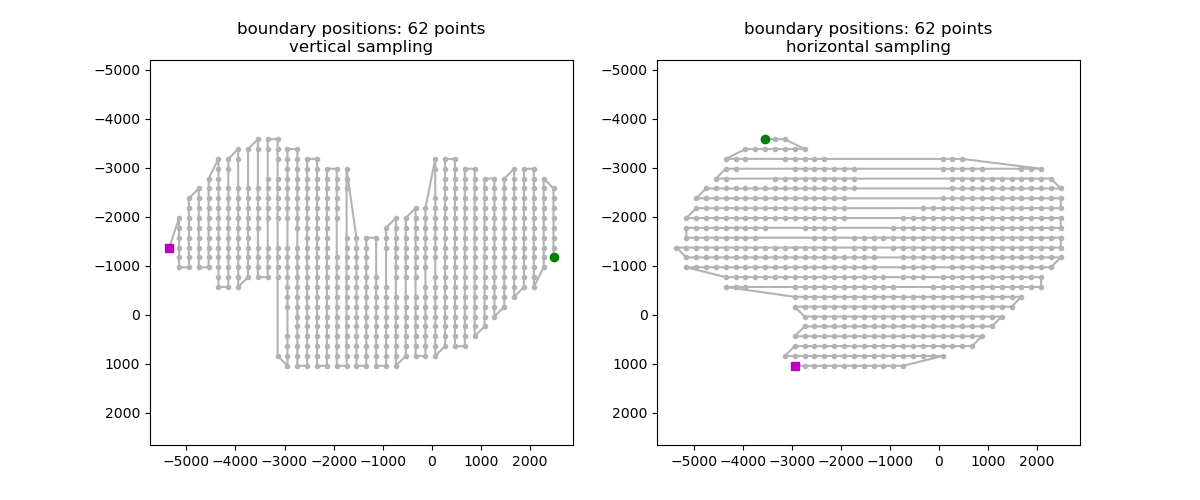

In [129]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))
"""
plot vertical snake
"""
ax[0].plot(coords_vert[:,0], coords_vert[:,1], '.-', color=[.7,.7,.7])
ax[0].plot(coords_vert[0,0], coords_vert[0,1], 's', color='m')
ax[0].plot(coords_vert[-1,0], coords_vert[-1,1], 'o', color='g')

# plot boundary and centroid
# ax[0].plot(*poly.exterior.xy, '.-')
# ax[0].plot(*poly.centroid.xy,'o')
ax[0].set_title(f'boundary positions: {len(points)} points\nvertical sampling')
ax[0].axis('equal')
ax[0].invert_yaxis()

"""
plot vertical snake
"""
ax[1].plot(coords_horiz[:,0], coords_horiz[:,1], '.-', color=[.7,.7,.7])
ax[1].plot(coords_horiz[0,0], coords_horiz[0,1], 's', color='m')
ax[1].plot(coords_horiz[-1,0], coords_horiz[-1,1], 'o', color='g')
aded

# plot boundary and centroid
# ax[1].plot(*poly.exterior.xy, '.-')
# ax[1].plot(*poly.centroid.xy,'o')
ax[1].set_title(f'boundary positions: {len(points)} points\nhorizontal sampling')
ax[1].axis('equal')
ax[1].invert_yaxis()

In [130]:
def compute_grid_indices(spc, step_size):
    """
    Map continuous coordinates to integer grid indices (ix, iy), starting at 0.
    spc: (N, 2) array
    """
    spc = np.asarray(spc, dtype=float)
    x = spc[:, 0]
    y = spc[:, 1]

    x0 = x.min()
    y0 = y.min()

    # Convert to indices; small eps to avoid floating errors
    eps = 1e-9
    ix = ((x - x0) / step_size + eps).astype(int)
    iy = ((y - y0) / step_size + eps).astype(int)

    return ix, iy


def select_side_indices(spc, ix, iy, return_side):
    """
    Given snake-path coordinates and their grid indices, return the indices
    of points on the chosen side: 'top', 'bottom', 'left', 'right'.
    """
    spc = np.asarray(spc)
    return_side = return_side.lower()
    if return_side not in {"top", "bottom", "left", "right"}:
        raise ValueError("return_side must be one of: 'top', 'bottom', 'left', 'right'")

    indices = np.arange(spc.shape[0])

    selected = []

    if return_side in {"top", "bottom"}:
        # Group by column (ix)
        for col in np.unique(ix):
            mask = ix == col
            col_indices = indices[mask]
            col_iy = iy[mask]

            if return_side == "top":
                # max iy in this column
                k = np.argmax(col_iy)
            else:  # bottom
                k = np.argmin(col_iy)

            selected.append(col_indices[k])

    else:  # 'left' or 'right'
        # Group by row (iy)
        for row in np.unique(iy):
            mask = iy == row
            row_indices = indices[mask]
            row_ix = ix[mask]

            if return_side == "right":
                # max ix in this row
                k = np.argmax(row_ix)
            else:  # left
                k = np.argmin(row_ix)

            selected.append(row_indices[k])

    # Deduplicate and sort in path order
    selected = sorted(set(selected))
    return np.array(selected, dtype=int)


def reorder_snake_by_side(spc, step_size, return_side):
    """
    Reorder snake-path coordinates so that the points on the requested side
    ('top', 'bottom', 'left', 'right') are moved to the end of the sequence,
    in reversed relative order.

    Additionally:
      - If index 0 (the first point) is part of that side set, it is *not* moved.

    Returns:
        new_spc: (N, 2) array with reordered coordinates
        side_indices: original indices that were moved (after removing 0 if present)
    """
    spc = np.asarray(spc, dtype=float)
    N = spc.shape[0]

    ix, iy = compute_grid_indices(spc, step_size)
    side_idxs = select_side_indices(spc, ix, iy, return_side)

    # Remove index 0 from the side set, if present
    side_idxs = side_idxs[side_idxs != 0]

    # All indices
    all_idxs = np.arange(N)

    # Indices that stay in place (relative order preserved)
    stay_mask = np.ones(N, dtype=bool)
    stay_mask[side_idxs] = False
    stay_idxs = all_idxs[stay_mask]

    # Side indices appended in reversed relative order
    moved_idxs = side_idxs[::-1]

    new_order = np.concatenate([stay_idxs, moved_idxs])
    new_spc = spc[new_order]

    return new_spc, side_idxs

In [140]:
def path_stats(snake_path_coordinates):
    """
    Compute total path length and largest distance between
    consecutive points in a path.

    Parameters
    ----------
    snake_path_coordinates : array-like of shape (N, 2)
        Ordered coordinates of the path.

    Returns
    -------
    total_length : float
        Sum of Euclidean distances between consecutive points.
    max_step : float
        Maximum Euclidean distance between any two consecutive points.
    """
    coords = np.asarray(snake_path_coordinates, dtype=float)

    if coords.shape[0] < 2:
        return 0.0, 0.0

    # Differences between consecutive points
    diffs = coords[1:] - coords[:-1]          # shape (N-1, 2)
    dists = np.linalg.norm(diffs, axis=1)     # shape (N-1,)

    total_length = dists.sum()
    max_step = dists.max()

    return total_length, max_step

In [138]:
reordered_coords_vert , side_vert_idx = reorder_snake_by_side(coords_vert, step_size, 'top')
reordered_coords_horiz, side_horiz_idx = reorder_snake_by_side(coords_horiz, step_size, 'left')

<IPython.core.display.Javascript object>


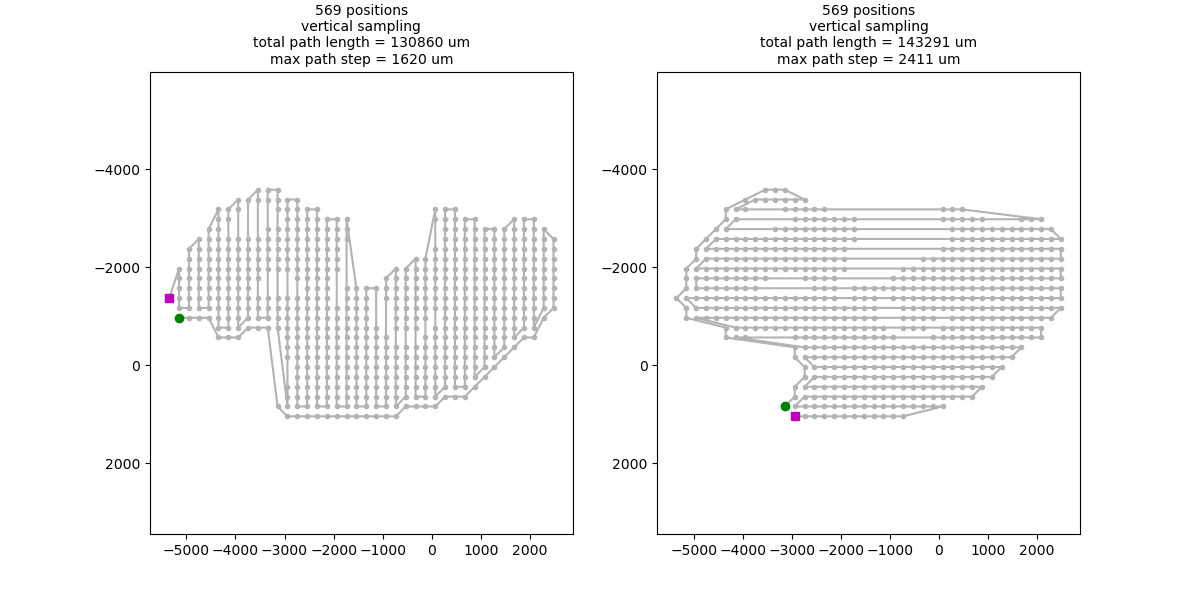

In [147]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,6))
"""
plot vertical snake
"""
xx = reordered_coords_vert[:,0]
yy = reordered_coords_vert[:,1]

ax[0].plot(xx, yy, '.-', color=[.7,.7,.7])
ax[0].plot(xx[0], yy[0], 's', color='m')
ax[0].plot(xx[-1], yy[-1], 'o', color='g')

tot_length, max_step = path_stats(reordered_coords_vert)
ax[0].set_title(f'{reordered_coords_vert.shape[0]} positions\n' + \
                  'vertical sampling\n' + \
                f'total path length = {tot_length:.0f} um\n'+ \
                f'max path step = {max_step:.0f} um', 
                fontsize=10)
ax[0].axis('equal')
ax[0].invert_yaxis()

"""
plot vertical snake
"""
xx = reordered_coords_horiz[:,0]
yy = reordered_coords_horiz[:,1]

ax[1].plot(xx, yy, '.-', color=[.7,.7,.7])
ax[1].plot(xx[0], yy[0], 's', color='m')
ax[1].plot(xx[-1], yy[-1], 'o', color='g')

tot_length, max_step = path_stats(reordered_coords_horiz)
ax[1].set_title(f'{reordered_coords_horiz.shape[0]} positions\n' + \
                  'vertical sampling\n' + \
                f'total path length = {tot_length:.0f} um\n'+ \
                f'max path step = {max_step:.0f} um', 
                fontsize=10)
ax[1].axis('equal')
ax[1].invert_yaxis()

In [134]:
reordered_coords_vert

(array([[-5351.401 , -1371.0938],
        [-5150.4922, -1772.9114],
        [-5150.4922, -1572.0026],
        ...,
        [-4748.6746, -2576.5466],
        [-4949.5834, -2375.6378],
        [-5150.4922, -1973.8202]]),
 array([  1,  14,  15,  33,  34,  60,  61,  84,  85, 106, 107, 138, 139,
        182, 183, 225, 226, 260, 261, 288, 289, 311, 312, 340, 341, 370,
        371, 408, 409, 447, 448, 481, 482, 510, 511, 537, 538, 560, 561]))